In [1]:
!pip install yfinance scikit-learn matplotlib tensorflow --quiet

# 📚 Imports

In [19]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 📥 Load AAPL Stock Data

In [6]:
df = yf.download('AAPL', start='2023-01-01', end='2025-04-03')
df = df[['Close']].dropna()
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2025-03-27,223.850006
2025-03-28,217.899994
2025-03-31,222.130005
2025-04-01,223.190002
2025-04-02,223.889999



# 📈 LINEAR REGRESSION MODEL

In [7]:
df['Day'] = np.arange(len(df))
X = df[['Day']]
y = df['Close']

# Train-Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train LR Model

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# Evaluation

In [11]:
print("📊 Linear Regression Metrics:")
print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

📊 Linear Regression Metrics:
R² Score: -0.8547627053338096
MAE: 12.628707824536372
RMSE: 14.945005388782821


# 📉 LSTM MODEL

In [12]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

# Sequence Prep

In [13]:
X_lstm, y_lstm = [], []
lookback = 60
for i in range(lookback, len(scaled_data)):
    X_lstm.append(scaled_data[i - lookback:i, 0])
    y_lstm.append(scaled_data[i, 0])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

# Train-Test Split for LSTM

In [14]:
split = int(0.8 * len(X_lstm))
X_train, X_test = X_lstm[:split], X_lstm[split:]
y_train, y_test = y_lstm[:split], y_lstm[split:]

# Build LSTM Model

In [15]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Train LSTM Model

In [16]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.1038
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0068
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0041
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0039
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0027
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0023
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0021
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0022
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0021
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0019


# Predictions

In [17]:
predictions = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predictions)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


# Plot LSTM Output

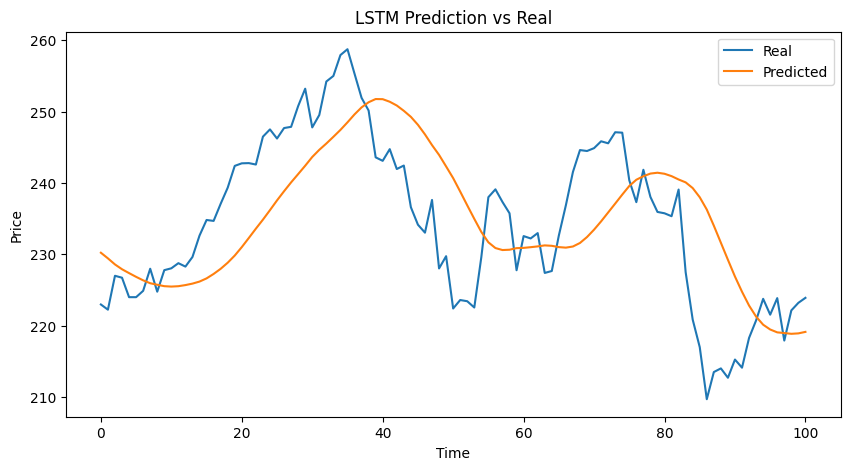

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(real_prices, label='Real')
plt.plot(predicted_prices, label='Predicted')
plt.title("LSTM Prediction vs Real")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

# --- LINEAR REGRESSION FINAL PREDICTION ---

In [21]:
future_day = len(df) + (datetime(2025, 4, 16) - df.index[-1]).days
future_lr_pred = lr_model.predict([[future_day]])
print(f"📘 Linear Regression Predicted Price on 2025-04-16: ${future_lr_pred[0].item():.2f}")

📘 Linear Regression Predicted Price on 2025-04-16: $237.35


# --- LSTM Prediction ---

In [22]:
last_60_days = scaled_data[-60:]
X_future = np.array([last_60_days])
X_future = X_future.reshape((1, 60, 1))

lstm_pred_scaled = model.predict(X_future)
future_lstm_pred = scaler.inverse_transform(lstm_pred_scaled)
print(f"📙 LSTM Predicted Price on 2025-04-16: ${future_lstm_pred[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
📙 LSTM Predicted Price on 2025-04-16: $219.45


# 🎯 Recommended Final Predicted Price

In [23]:
Final_Price = (0.4 * future_lr_pred.item()) + (0.6 * future_lstm_pred[0][0])
print(f"✅ Recommended Final Predicted Price: ${Final_Price:.2f}")

✅ Recommended Final Predicted Price: $226.61
